Parameter Heatmap
==========

This tutorial will show how to optimize strategies with multiple parameters and how to examine and reason about optimization results.
It is assumed you're already familiar with
[basic _backtesting.py_ usage](https://kernc.github.io/backtesting.py/doc/examples/Quick Start User Guide.html).

First, let's again import our helper moving average function.
In practice, one should use functions from an indicator library, such as
[TA-Lib](https://github.com/mrjbq7/ta-lib) or
[Tulipy](https://tulipindicators.org).

In [ ]:
from backtesting.test import SMA

Our strategy will be a similar moving average cross-over strategy to the one in
[Quick Start User Guide](https://kernc.github.io/backtesting.py/doc/examples/Quick Start User Guide.html),
but we will use four moving averages in total:
two moving averages whose relationship determines a general trend
(we only trade long when the shorter MA is above the longer one, and vice versa),
and two moving averages whose cross-over with daily _close_ prices determine the signal to enter or exit the position.

In [ ]:
from backtesting import Strategy
from backtesting.lib import crossover


class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 20
    n_exit = 10
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)
        
    def next(self):
        
        if not self.position:
            
            # On upwards trend, if price closes above
            # "entry" MA, go long
            
            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()
                    
            # On downwards trend, if price closes below
            # "entry" MA, go short
            
            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        
        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.sma_exit)):
                
                self.position.close()

It's not a robust strategy, but we can optimize it. Let's optimize our strategy on Google stock data.

In [ ]:
%%time 

from backtesting import Backtest
from backtesting.test import GOOG


backtest = Backtest(GOOG, Sma4Cross, commission=.002)

stats, heatmap = backtest.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    n_enter=range(15, 35, 5),
    n_exit=range(10, 25, 5),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    return_heatmap=True)

Notice `return_heatmap=True` parameter passed to
[`Backtest.optimize()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.optimize).
It makes the function return a heatmap series along with the usual stats of the best run.
`heatmap` is a pandas Series indexed with a MultiIndex, a cartesian product of all permissible parameter values.
The series values are from the `maximize=` argument we provided.

In [ ]:
heatmap

This heatmap contains the results of all the runs,
making it very easy to obtain parameter combinations for e.g. three best runs:

In [ ]:
heatmap.sort_values().iloc[-3:]

But we use vision to make judgements on larger data sets much faster.
Let's plot the whole heatmap by projecting it on two chosen dimensions.
Say we're mostly interested in how parameters `n1` and `n2`, on average, affect the outcome.

In [ ]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm

Let's plot this table using the excellent [_Seaborn_](https://seaborn.pydata.org) package:

In [ ]:
%matplotlib inline

import seaborn as sns


sns.heatmap(hm[::-1], cmap='viridis')

We see that, on average, we obtain the highest result using trend-determining parameters `n1=40` and `n2=60`,
and it's not like other nearby combinations work similarly well — in our particular strategy, this combination really stands out.

Since our strategy contains several parameters, we might be interested in other relationships between their values.
We can use
[`backtesting.lib.plot_heatmaps()`](https://kernc.github.io/backtesting.py/doc/backtesting/lib.html#backtesting.lib.plot_heatmaps)
function to plot interactive heatmaps of all parameter combinations simultaneously.

In [ ]:
from backtesting.lib import plot_heatmaps


plot_heatmaps(heatmap, agg='mean')

## Stochastic optimization
In the previous method, we used a *Grid Search* method. The *Grid Search* is an exhaustive search through a set of manually specified set of values of hyperparameters. You evaluate the performance for each set of parameters and finally select the one that performed best. This however might be computationally expensive for large data sets. In the follwing example, we will use *skopt.forest_minimize* from *scikit-optimize* which is a sequential optimization method using decision trees. This is suitable for modeling the expensive to evaluate functions. The model is improved by sequentially evaluating the expensive function at the next best point. Thereby finding the parameters producing the optimum value for the function with as few evaluations as possible.  

In [32]:
stats_skopt, optimization, heatmap_skopt = backtest.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    n_enter=range(15, 35, 5),
    n_exit=range(10, 25, 5),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=200,
    return_heatmap=True,
    return_optimization=True)

In [33]:
optimization.x

[26, 152, 16, 17]

Understanding the impact of each parameter on the function in two dimensions is easy, but partial dependency subplots start to be useful when the number of dimensions grows. The *skopt.plots* methods *plots.plot_evaluations* and *plots.plot_objective*  take care of many of the more mundane things needed to make good plots of all combinations of the dimensions.

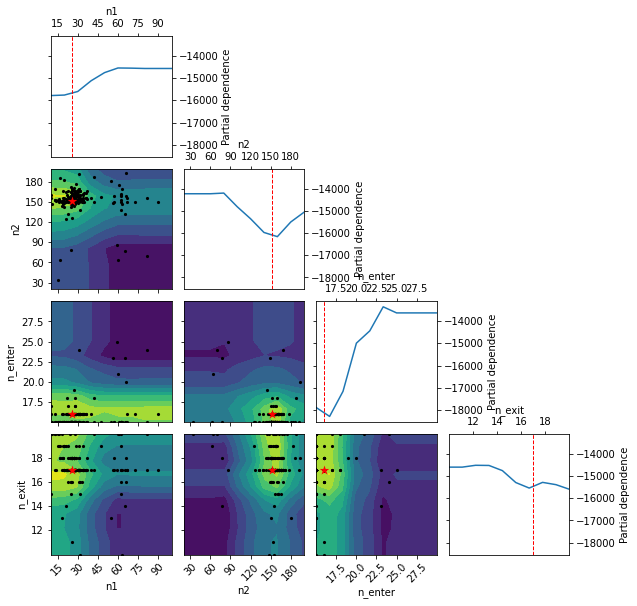

In [34]:
from skopt.plots import plot_objective

_ = plot_objective(optimization, n_points=10)


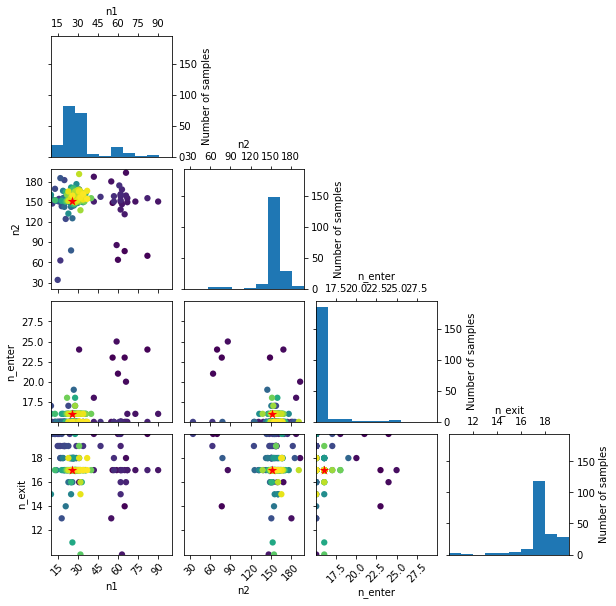

In [35]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(optimization, bins=10)

Learn more by exploring further
[examples](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#tutorials)
or find more framework options in the
[full API reference](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#header-submodules).